In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout,Flatten,BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import load_model
import os, random

In [4]:
INP_SIZE = 25

In [5]:
model = load_model("S-EWSNet") ######load the deep learning model trained on optimally sampled data

2023-11-15 17:26:49.515121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-15 17:26:49.739017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-11-15 17:26:49.739109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-11-15 17:26:49.739160: I tensorflow/core/com

In [6]:
v = open("./data1").read().split('\n')   ######insert your sequence of snapshots and test on S-EWSNet
v = np.array([[int(y) for y in x.split()] for x in v[:-1]])
v = v.reshape((-1,128,128))

(101,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
1/1 [==============================] - 0s 17ms/step


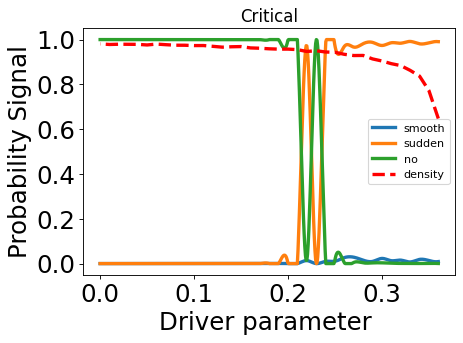

In [8]:
###################pass test data and sample optimally to return the probability of the type of transition (smo###oth/gradual, critical/sudden) or no transition
##################plot the data and the prediction probability of each type of transition
import matplotlib.pyplot as plt
p_vals = np.array([x/100 for x in range(0,v.shape[0])])
densities = np.array([np.mean(x) for x in v])
imgs = v
print(p_vals.shape)
print(p_vals)
out_prob = []
bs = [[] for _ in range(101)]
deld = 0.01
for d,p,img in zip(densities[::-1],p_vals[::-1],imgs[::-1]):
    if d < 0.1 :continue
    curr_bin = int(d//deld)
    bs[curr_bin].append(img)
    x = []
    img = np.fft.fft2(img)[:INP_SIZE,:INP_SIZE]
    x.append(np.stack([np.real(img), np.imag(img)],axis=2))
    for i in range(curr_bin+1, 100):
        if len(bs[i])==0: continue
        new_img = random.choice(bs[i])
        new_img = np.fft.fft2(new_img)[:INP_SIZE,:INP_SIZE]
        x.append(np.stack([np.abs(new_img), np.angle(new_img)],axis=2))
    x = x[:5]
    x.reverse()
    if len(x)<5:
        out_prob.append((p,[0,0,1]))
    else:
        out_prob.append((p,model.predict(np.array([x]))[0]))
    
from scipy.interpolate import make_interp_spline
    
plt.figure(figsize=(6, 4), dpi=80)
for t in range(3):
    x_axis = np.array([1-x[0] for x in out_prob])
    y_axis = np.array([x[1][t] for x in out_prob])
    x_axis_ = np.linspace(x_axis.min(), x_axis.max(), 500)
    spline = make_interp_spline(x_axis, y_axis)
    y_axis_ = spline(x_axis_)
    plt.plot(x_axis_,[min(max(x,0),1) for x in y_axis_],'-',label = ['smooth', 'sudden', 'no'][t],linewidth=3)
plt.xlabel("Driver parameter ",size=22)
plt.ylabel("Probability Signal",size=22)
plt.title(f"Critical",size=15)
plt.xticks([0.0,0.1,0.2,0.3,0.4],size=22)
plt.yticks(size=22)
plt.plot([x for x,y in zip(1-p_vals, densities) if y>0.1], [y for x,y in zip(1-p_vals, densities) if y>0.1], '--',color='r', label="density",linewidth=3)
plt.legend()